Pytorch Neural Network Modules
==============================

Pytorch uses the `torch.nn.Module` class to represent a neural network.

A `Module` is just a **callable** function that can be:

 * **Parameterized** by trainable `Parameter` tensors that the module can list out.
 * **Composed** out of children `Module`s that contribute parameters.
 * **Saved and Loaded** by listing named parameters and other attribute buffers.

Pytorch comes with several built-in elementary network modules, like a generic single-layer `Linear` network, or a generic `Sequential` composition of other networks, but of course you can write your own `Module` subclasses by just defining `Parameter` attributes and using them to implement a computation.

To see how every `Module` manages its own portion of responsibilities of all the network duties above, we first look at how to use the built-in `Linear` and `Sequential` modules.

Using torch.nn.Linear as a Neural Network
=========================================

The linear layer is not just a good starting example: it is the fundmental workhorse of all neural networks, so as simple as it is, it is worth examining carefully.

`torch.nn.Linear` implements the function `y = Ax + b`, which takes m-dimensional input `x` and produces n-dimensional output `y`, by multiplying by the n &times; m matrix `A` (whose specific values are called the `weight`) and adding n-dimensional vector `b` (whose values are called the `bias`).  We can make a Linear network with 3d input and 2d output just like this:

In [32]:
import torch
net = torch.nn.Linear(3, 2)
print(net)

Linear(in_features=3, out_features=2, bias=True)


Like any Module, our little network can be run as a function.  As expected, when we give it 3-d vector as input, we get a 2-d vector as output.

In [33]:
net(torch.tensor([[1.0, 0.0, 0.0]]))

tensor([[-0.2287, -0.2902]], grad_fn=<AddmmBackward0>)

**Batchwise processing is assumed in pytorch networks.** Notice the double nesting in the vector data above.  This is needed because our `Linear`  network is slightly different from a plain matrix-vector multiplication. By convention, pytorch `Module`s are set up to process data in batches, so to give it a single 3-d vector, instead of passing just a vector, we have passed it a singleton batch containing one vector.

We can instead send in several inputs - here we provide four vectors as inputs.  The network then gives us four vectors as outputs:

In [34]:
x_batch = torch.tensor([
    [1.0, 0. , 0. ],
    [0. , 1.0, 0. ],
    [0. , 0. , 1.0],
    [0. , 0. , 0. ],
])
net(x_batch)

tensor([[-0.2287, -0.2902],
        [-0.2508, -0.3087],
        [-0.1594, -0.6448],
        [ 0.1796, -0.3067]], grad_fn=<AddmmBackward0>)

**Parameters are randomly initializated by default.** What strange function is this Linear layer computing?  By default pytorch has initialized the weights and bias randomly.  We can look at these random parameters directly:

In [35]:
print('weight is', net.weight)
print('bias is', net.bias)

weight is Parameter containing:
tensor([[-0.4082, -0.4304, -0.3390],
        [ 0.0166, -0.0019, -0.3381]], requires_grad=True)
bias is Parameter containing:
tensor([ 0.1796, -0.3067], requires_grad=True)


### Exercise

1. Set the `bias` of the network to the zero vector.
2. Examine the numerical results of `net(x_batch)`.  Do the answers match the parameters as you would expect?

**Hint**: although `x.zero_()` or `x[:] = 0.0` can zero a vector in place, since the network parameters are all `requires_grad=True`, you will need to put things in a `with torch.no_grad()` block to temporarily disable autograd before changing the values.

In [36]:
# TODO: Set the bias of the network to the zero vector.
with torch.no_grad():
  net.bias = net.bias.zero_()
# TODO: Compare the numerical results of net(x_batch) to the parameters.
print(x_batch, net(x_batch), net.weight, net.bias)

tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 0.]]) tensor([[-0.4082,  0.0166],
        [-0.4304, -0.0019],
        [-0.3390, -0.3381],
        [ 0.0000,  0.0000]], grad_fn=<AddmmBackward0>) Parameter containing:
tensor([[-0.4082, -0.4304, -0.3390],
        [ 0.0166, -0.0019, -0.3381]], requires_grad=True) Parameter containing:
tensor([0., 0.], requires_grad=True)


**Parameters are set up for autograd and optimization, and can be listed out.**  Above you can see that both the weight and the bias are trainable parameters, because they both have the `Parameter` type.  The tensors also both marked as `requires_grad=True`, which means they are marked to participate in autograd and optimization for training.

These are the only two trainable parameters of the network.  To check this, we can list all parameters by name, using `net.named_parameters()`.

In [37]:
for name, param in net.named_parameters():
    print(f'{name} = {param}\n')

weight = Parameter containing:
tensor([[-0.4082, -0.4304, -0.3390],
        [ 0.0166, -0.0019, -0.3381]], requires_grad=True)

bias = Parameter containing:
tensor([0., 0.], requires_grad=True)



**A Module can be saved by saving its state_dict.**   `net.state_dict()` is similar to `net.named_parameters()` but it returns a detached reference to the data (that is, `requires_grad=False`) so the data can be saved directly.  Also, for more complicated modules, `state_dict()` may include other non-trainable attributes that are needed to save the network's state.

In [38]:
for k, v in net.state_dict().items():
    print(f'{k}: {v.type()}{tuple(v.shape)}')

import os
os.makedirs('checkpoints', exist_ok=True)
torch.save(net.state_dict(), 'checkpoints/linear.pth')

weight: torch.FloatTensor(2, 3)
bias: torch.FloatTensor(2,)


**load_state_dict() can be used to reload a saved Module.**  Pytorch also comes with convenient `torch.save` and `torch.load` functions for saving state dicts to files.

In [39]:
# Then later, to remember the state
net.load_state_dict(torch.load('checkpoints/linear.pth'))

<ipython-input-39-a295d3448eca>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('checkpoints/linear.pth'))


<All keys matched successfully>

### Exercise:

1. Define a linear layer **without** bias, as in `net2 = torch.nn.Linear(3, 2, bias=False)`.
2. Load the previously saved state dict in 'checkpoints/linear.pth' into this new layer, ignoring the saved bias.

Loading trained parameters from one network into a different network with a changed architecture is a more common trick than you might imagine.  It is the core technique of *transfer learning*.

**Hint**: you can get pytorch to do this in a couple ways.  One way is to manually change the dictionary keys, in this case deleting the `bias` parameter from the state dict after loading it from the file and before passing it to `net2.load_state_dict`.  The other way is to try the `strict=False` option on load_state_dict, which will print a warning about the mismatch but proceed anyway.


In [40]:
# TODO: define net2 without bias.
net2 = torch.nn.Linear(3, 2, bias=False)
# TODO: load the previously saved state dict, ignoring the saved bias.
net2.load_state_dict(torch.load('checkpoints/linear.pth'), strict=False)

<ipython-input-40-af99a27dbaaf>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net2.load_state_dict(torch.load('checkpoints/linear.pth'), strict=False)


_IncompatibleKeys(missing_keys=[], unexpected_keys=['bias'])

Training Example: Optimizing a Linear Layer
-------------------------------------------

To train a network we need to come up with a score for how close we are to the goal.  This scalar number is called the **objective** or the **loss**.

For example, suppose we would like this network to always output `[1, 1]` regardless of input.  Then a reasonable loss would be the mean squared distance to `[1, 1]`, computed like this:

In [41]:
y_batch = net(x_batch)
loss = ((y_batch - torch.tensor([[1.0, 1.0]])) ** 2).sum(1).mean()
print(f'loss is {loss}')

loss is 2.895927667617798


We can use autograd get gradients to see how small changes in every parameter would impact the loss.

In [42]:
loss.backward()
print(f'weight is {net.weight} and grad is:\n{net.weight.grad}\n')
print(f'bias is {net.bias} and grad is:\n{net.bias.grad}\n')

weight is Parameter containing:
tensor([[-0.4082, -0.4304, -0.3390],
        [ 0.0166, -0.0019, -0.3381]], requires_grad=True) and grad is:
tensor([[-0.7041, -0.7152, -0.6695],
        [-0.4917, -0.5010, -0.6691]])

bias is Parameter containing:
tensor([0., 0.], requires_grad=True) and grad is:
tensor([-2.5888, -2.1618])



**Simple gradient descent can be done directly.**  To improve our layer, we can use simple gradient descent with a learning rate of 0.01.  That is, we can adjust each parameter by subtracting 0.01 times the gradient.  If we do this repeatedly, we should get closer to our objective.

Any time we directly update the network parameters, we need to temporarily disable the autograd machinery using `with torch.no_grad()`.

weight is Parameter containing:
tensor([[8.4369e-06, 8.4365e-06, 8.4367e-06],
        [7.4333e-06, 7.4328e-06, 7.4333e-06]], requires_grad=True)

bias is Parameter containing:
tensor([1.0000, 1.0000], requires_grad=True)



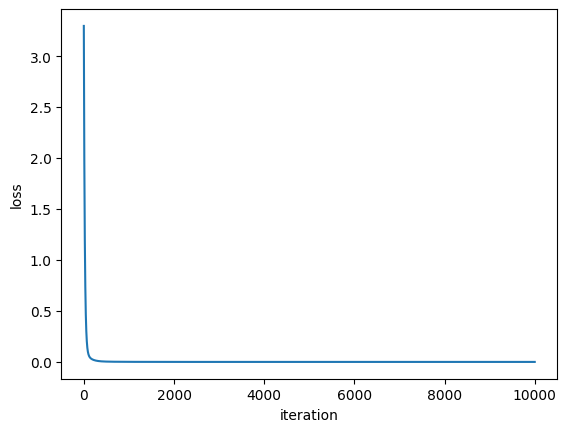

In [43]:
net = torch.nn.Linear(3, 2)
log = []
for _ in range(10000):
    y_batch = net(x_batch)
    loss = ((y_batch - torch.tensor([[1.0, 1.0]])) ** 2).sum(1).mean()
    log.append(loss.item())
    net.zero_grad()
    loss.backward()
    with torch.no_grad():
        for p in net.parameters():
            p[...] -= 0.01 * p.grad
print(f'weight is {net.weight}\n')
print(f'bias is {net.bias}\n')

%matplotlib inline
import matplotlib.pyplot as plt
plt.ylabel('loss')
plt.xlabel('iteration')
plt.plot(log)
plt.show()

### Exercise

1. Use `plt.yscale('log')` to plot the loss on a log scale.
2. Look directly at `net.bias` and use subtraction to see how far it is from (1,1).

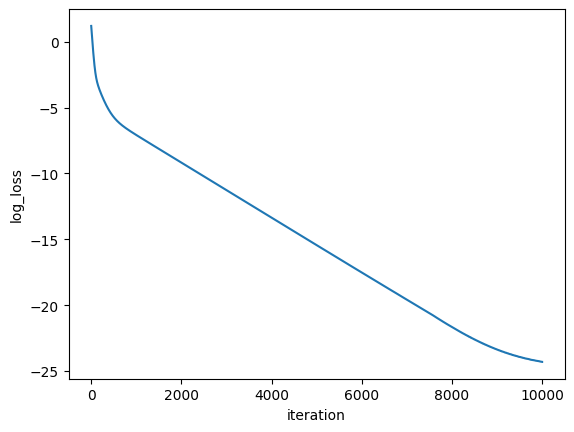

tensor([-7.7486e-06, -7.0333e-06], grad_fn=<SubBackward0>)


In [44]:
# TODO: Plot the evolution of the loss on a log scale.
plt.ylabel('log_loss')
plt.xlabel('iteration')
plt.plot(torch.log(torch.tensor(log)))
plt.show()
# TODO: Examine net.bias directly and compare to (1,1)
print(net.bias - torch.tensor([1.0, 1.0])) # very close!

Voila, we have trained a simple neural network to our desired objective of outputting a constant ones vector.  After a few thousand updates, the weight has a near-zero matrix, and the bias becomes `[1.0, 1.0]`, as desired.

**A realistic training loop would run on the GPU using bigger batches of randomized input and a prepackaged optimization algorithm.**

Below we create a newly randomized `Linear` net instance, and train it on the GPU using the Adam optimizer fo 1000 iterations.

weight is Parameter containing:
tensor([[ 8.4241e-09,  1.4930e-09, -4.2784e-09],
        [-2.2924e-08,  2.0012e-09, -1.5052e-09]], requires_grad=True)

bias is Parameter containing:
tensor([1.0000, 1.0000], requires_grad=True)



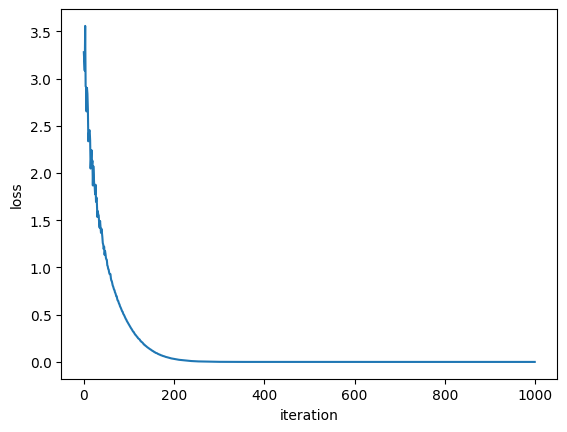

In [45]:
from torch.optim import Adam
net = torch.nn.Linear(3, 2)
optimizer = Adam(net.parameters(), lr=0.01)
# Move the network, target value, and training inputs to the GPU
# net.cuda()
target = torch.tensor([[1.0, 1.0]]) #, device='cuda')
log = []
for _ in range(1000):
    y_batch = net(torch.randn(100, 3)) # device='cuda'))
    loss = ((y_batch - target) ** 2).sum(1).mean()
    log.append(loss.item())
    net.zero_grad()
    loss.backward()
    optimizer.step()
print(f'weight is {net.weight}\n')
print(f'bias is {net.bias}\n')

%matplotlib inline
import matplotlib.pyplot as plt
plt.ylabel('loss')
plt.xlabel('iteration')
plt.plot(log)

### Exercise

1. Again, use `plt.yscale('log')` to plot the loss on a log scale.
2. Look directly at `net.bias` and use subtraction to see how far it is from (1,1).

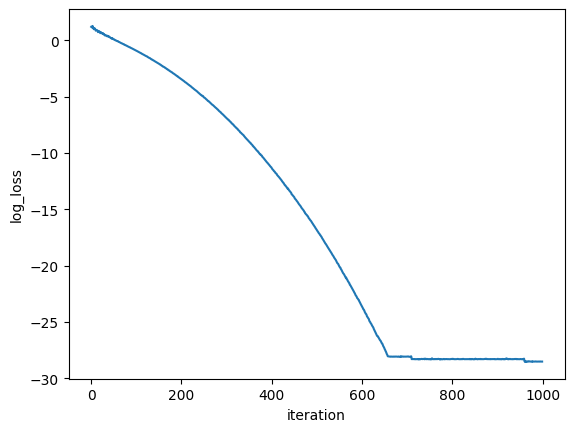

tensor([-5.3644e-07,  3.5763e-07], grad_fn=<SubBackward0>)


In [46]:
# TODO: Plot the evolution of the loss on a log scale again.
plt.ylabel('log_loss')
plt.xlabel('iteration')
plt.plot(torch.log(torch.tensor(log)))
plt.show()
# TODO: Examine net.bias directly.  How does Adam doo?
print(net.bias - torch.tensor([1.0, 1.0])) # also very close, and closer than just subtracting with a fixed learning rate

In [60]:
# This visulaization function is used for the next example

%matplotlib inline
from matplotlib import pyplot as plt

def visualize_net(net, classify_target):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    grid = torch.stack([
        torch.linspace(-2, 2, 100)[None, :].expand(100, 100),
        torch.linspace(2, -2, 100)[:, None].expand(100, 100),
    ])
    x, y = grid
    target = classify_target(x, y)
    ax1.set_title('target')
    ax1.imshow(target.float(), cmap='hot', extent=[-2,2,-2,2])
    ax2.set_title('network output')
    score = net(grid.permute(1, 2, 0).reshape(-1, 2).cpu()).softmax(1)
    ax2.imshow(score[:,1].reshape(100, 100).detach().cpu(), cmap='hot', extent=[-2,2,-2,2])
    plt.show()

from IPython.display import HTML
HTML('''<script>function toggle_code(){$('.rendered.selected div.input').toggle().find('textarea').focus();} $(toggle_code)</script>
<a href="javascript:toggle_code()">Toggle</a> the code for visualize_net.''')

Using torch.nn.Sequential to Compose Networks
---------------------------------------------

Unlike `Linear`, most networks are made by composing many smaller networks.  The simplest way to do this is chain networks together end-to-end, connecting each output to the next input.  For example we can simply compose `Linear` layers.

**Defining a Multilayer Perceptron.** Of course, to get something more interesting than another linear function, we need to do something nonlinear between the linear steps.  if we add a nonlinearity between each step (for example, if we clamp negative numbers to zero - an operation called `ReLU`), then we can get a **Multilayer Perceptron,** which is known to be a universal function approximator, i.e., a family of piecewise-linear functions that can approximate any function.


Here is how we can express the network as a nested set of Sequentials.

In [64]:
from collections import OrderedDict
from torch.nn import Linear, ReLU, Sequential

mlp = torch.nn.Sequential(OrderedDict([
    ('layer1', Sequential(Linear(2, 20), ReLU())),
    ('layer2', Sequential(Linear(20, 20), ReLU())),
    ('layer3', Sequential(Linear(20, 2)))
]))

print(mlp)

Sequential(
  (layer1): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): ReLU()
  )
  (layer2): Sequential(
    (0): Linear(in_features=20, out_features=20, bias=True)
    (1): ReLU()
  )
  (layer3): Sequential(
    (0): Linear(in_features=20, out_features=2, bias=True)
  )
)


In the above, we have nested two levels of Sequentials.  In the outermost level, we have defined and named three layers.

Then each layer is itself a Sequential that executes a parameterized `Linear` operation followed by a `ReLU` nonlinear clamping operation.  We have not bothered to name each of the innermost steps, so the Sequential just automatically numbers them.

**Every submodule has a fully qualified name.** We can get a full recursive list of submodules by listing `net.named_modules()`.

In [65]:
for n, c in mlp.named_modules():
    print(f'{n or "The whole network"} is a {type(c).__name__}')

The whole network is a Sequential
layer1 is a Sequential
layer1.0 is a Linear
layer1.1 is a ReLU
layer2 is a Sequential
layer2.0 is a Linear
layer2.1 is a ReLU
layer3 is a Sequential
layer3.0 is a Linear


**A module's parameters include all its child module parameters.** We can see this by listing all the parameters by name.    

In [66]:
for name, param in mlp.named_parameters():
    print(f'{name} has shape {tuple(param.shape)}')

layer1.0.weight has shape (20, 2)
layer1.0.bias has shape (20,)
layer2.0.weight has shape (20, 20)
layer2.0.bias has shape (20,)
layer3.0.weight has shape (2, 20)
layer3.0.bias has shape (2,)


There are now six parameters: a weight and a bias for each of the three `Linear` layers.

**Training a Clasifier.** This slightly more complicated network can now represent a more general class of functions. For example, we can use this architecture to learn to compute a classifier function.  

Suppose we want to classify points on a plane as either above a sine-wave (class 1) or below a sine-wave (class 0). Here is the ordinary training loop to train our MLP to do it, using the Adam optimizer:


Iteration 0 accuracy: 0.3059999942779541


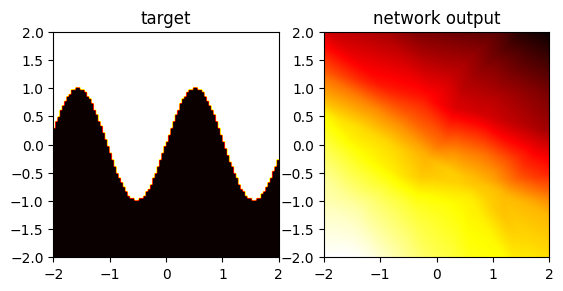

Iteration 1 accuracy: 0.3098999857902527


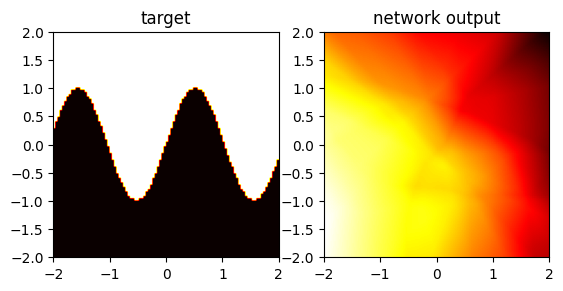

Iteration 3 accuracy: 0.6891999840736389


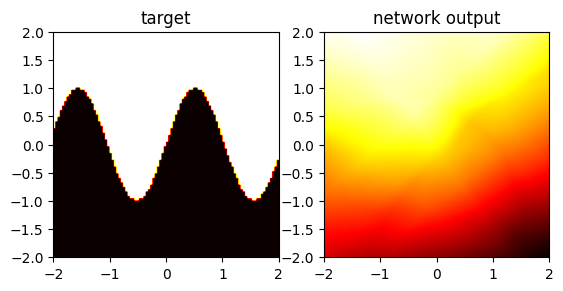

Iteration 7 accuracy: 0.7724000215530396


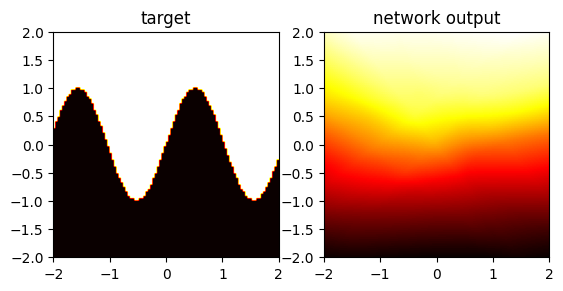

Iteration 15 accuracy: 0.7871999740600586


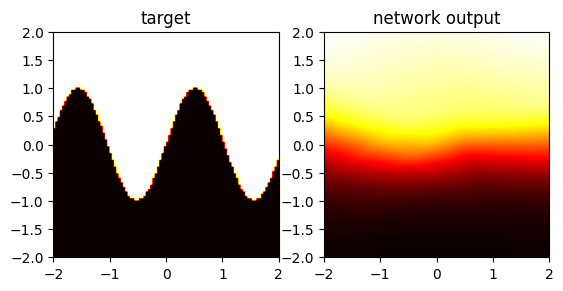

Iteration 31 accuracy: 0.8217999935150146


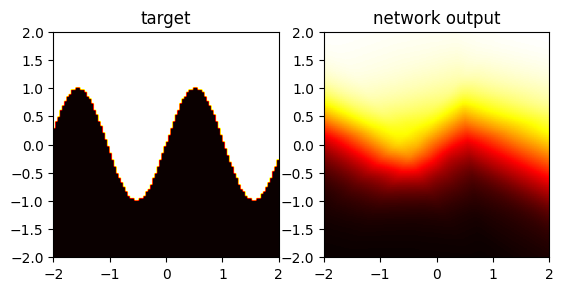

Iteration 63 accuracy: 0.9115999937057495


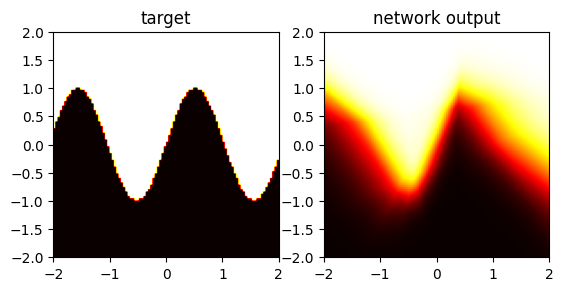

Iteration 127 accuracy: 0.9785000085830688


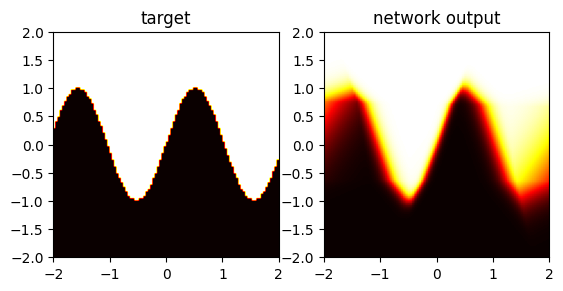

Iteration 255 accuracy: 0.9897000193595886


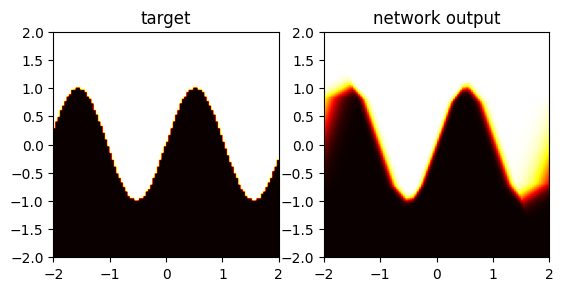

Iteration 511 accuracy: 0.9919000267982483


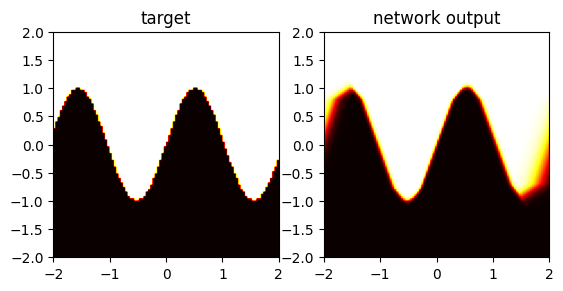

Iteration 1023 accuracy: 0.9940999746322632


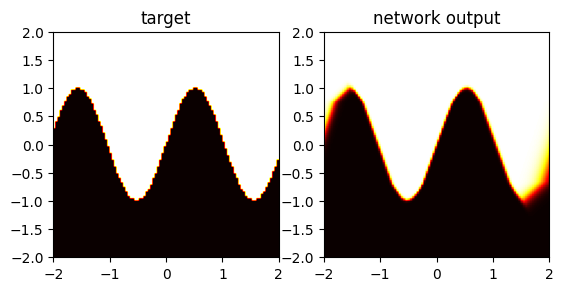

In [67]:
from torch.nn.functional import cross_entropy

def classify_target(x, y):
    return (y > (x * 3).sin()).long()

# mlp.cuda()
optimizer = Adam(mlp.parameters(), lr=0.01)
for iteration in range(1024):
    in_batch = torch.randn(10000, 2)#, device='cuda')
    # it is nice how this is parallelized!
    target_batch = classify_target(in_batch[:,0], in_batch[:,1])
    out_batch = mlp(in_batch)
    loss = cross_entropy(out_batch, target_batch)
    if iteration > 0:
        mlp.zero_grad()
        loss.backward()
        optimizer.step()
    if iteration == 2 ** iteration.bit_length() - 1:
        pred_batch = out_batch.max(1)[1]
        accuracy = (pred_batch == target_batch).float().sum() / len(in_batch)
        print(f'Iteration {iteration} accuracy: {accuracy}')
        visualize_net(mlp, classify_target)


### Exercise

1. Try another classification objective.  Try `(y > x**2).long()`.
2. Try another one: try `(y.floor() == x.floor()).long()`.
3. Make up another one to try.  Can you find a simple objective that the network has trouble matching?



In [ ]:
# TODO: repeat the experiment with `(y > x**2).long()` as the classification objective.
# TODO: use `(y.floor() == x.floor()).long()` as the objective.
# TODO: find a simple objective that the network has trouble matching.


**A network can be saved by saving its state_dict.**  Since the state_dict gathers together all the parameters of the submodules, we can save it all at once.  Note that since every parameter is given a fully-qualified name, if we wanted to load just a subset of the layers, we could do that by picking out keys of the dictionary and adjusting their names by hand.

In [54]:
for k, v in mlp.state_dict().items():
    print(f'{k}: {v.dtype}{tuple(v.shape)}')

torch.save(mlp.state_dict(), 'checkpoints/mlp.pth')


layer1.0.weight: torch.float32(20, 2)
layer1.0.bias: torch.float32(20,)
layer2.0.weight: torch.float32(20, 20)
layer2.0.bias: torch.float32(20,)
layer3.0.weight: torch.float32(2, 20)
layer3.0.bias: torch.float32(2,)


Defining `forward` to Create Custom Networks
--------------------------------

Sometimes you will want to hook up network components in a more complicated way than just a sequential operation of predefined components.

For example, [ResNet](https://arxiv.org/abs/1512.03385) is built on the observation that learning can work much better if, instead of learning an arbitrary linear operation, we learn perturbations of the identity.  I.e., have a layer learn to compute a small residual instead of the whole total answer.

To apply the residual trick in our little three-layer network, we cannot just use an overall `Sequential`: instead we will define the operation by writing our own `forward` function.  It looks like this:

MyNetwork(
  (layer1): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): ReLU()
  )
  (residual_layer2): Sequential(
    (0): Linear(in_features=20, out_features=20, bias=True)
    (1): ReLU()
  )
  (layer3): Linear(in_features=20, out_features=2, bias=True)
)
Iteration 0 accuracy: 0.998199999332428


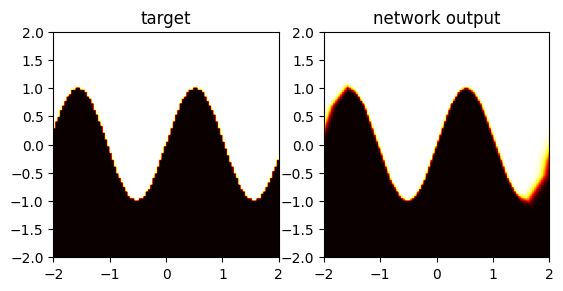

Iteration 1 accuracy: 0.9958000183105469


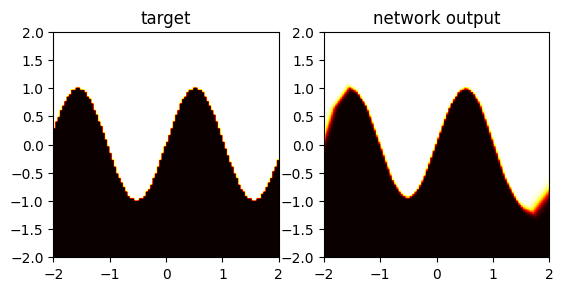

Iteration 3 accuracy: 0.9914000034332275


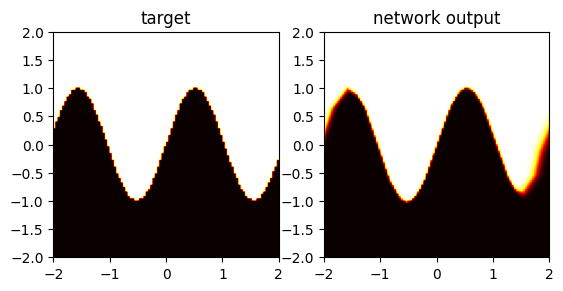

Iteration 7 accuracy: 0.9889000058174133


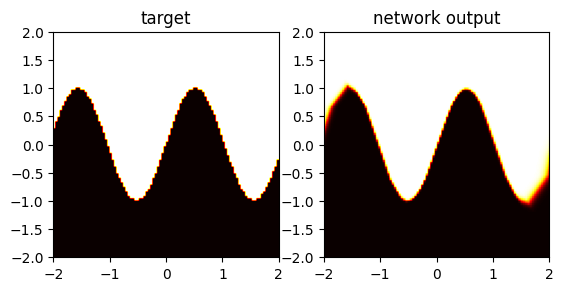

Iteration 15 accuracy: 0.9940000176429749


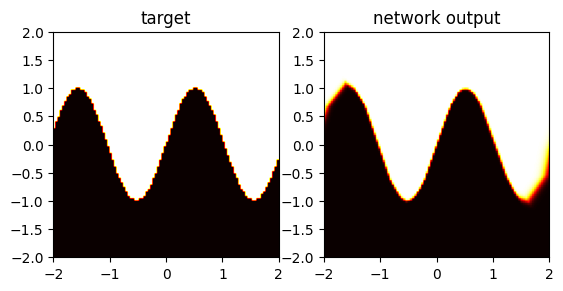

Iteration 31 accuracy: 0.9951000213623047


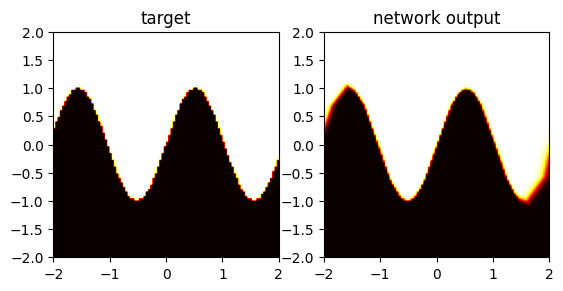

Iteration 63 accuracy: 0.9958999752998352


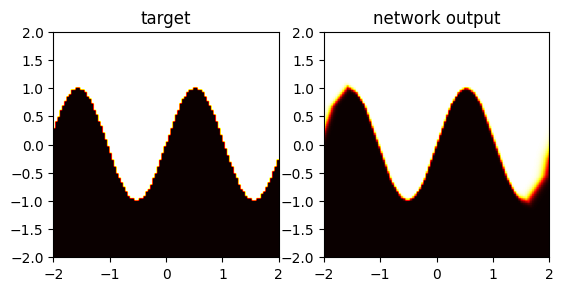

Iteration 127 accuracy: 0.9968000054359436


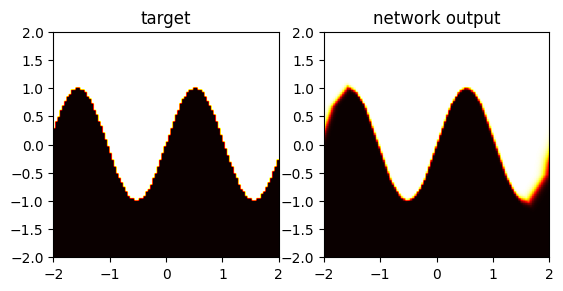

Iteration 255 accuracy: 0.9954000115394592


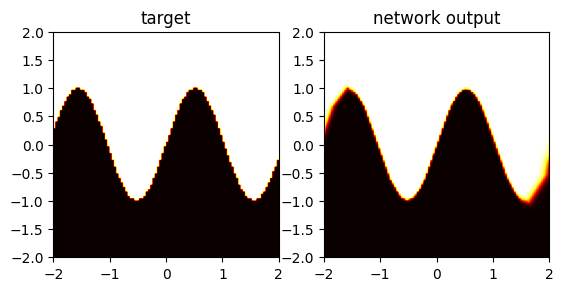

Iteration 511 accuracy: 0.9962000250816345


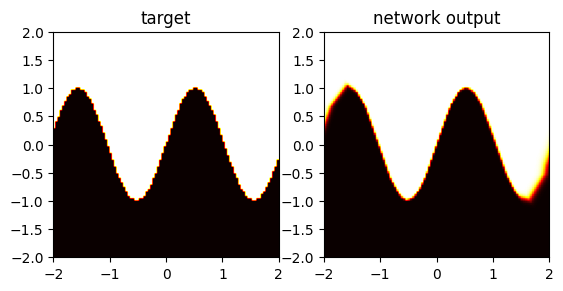

Iteration 1023 accuracy: 0.9947999715805054


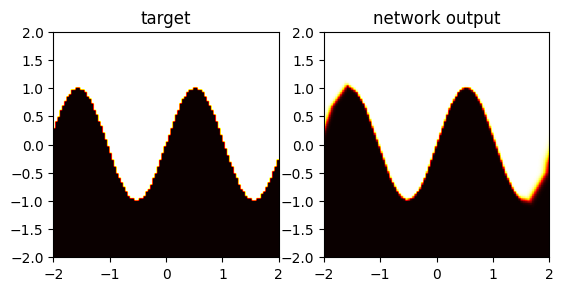

In [70]:
class MyNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = Sequential(Linear(2, 20), ReLU())
        self.residual_layer2 = Sequential(Linear(20, 20), ReLU())
        self.layer3 = Linear(20, 2)

    def forward(self, x):
        x = self.layer1(x)
        x = x + self.residual_layer2(x)
        x = self.layer3(x)
        return x

res_mlp = MyNetwork()
print(res_mlp)

# Exercise left to you: try training res_mlp just like we trained mlp above.

def classify_target(x, y):
    return (y > (x * 3).sin()).long()

optimizer = Adam(mlp.parameters(), lr=0.01)

for iteration in range(1024):
  in_batch = torch.randn(10000, 2)
  target_batch = classify_target(in_batch[:,0], in_batch[:,1])
  out_batch = mlp(in_batch)
  loss = cross_entropy(out_batch, target_batch)
  if iteration > 0:
    mlp.zero_grad()
    loss.backward()
    optimizer.step()
  if iteration == 2 ** iteration.bit_length() - 1:
        pred_batch = out_batch.max(1)[1]
        accuracy = (pred_batch == target_batch).float().sum() / len(in_batch)
        print(f'Iteration {iteration} accuracy: {accuracy}')
        visualize_net(mlp, classify_target)

Training the network above can be done exactly the same way as training our previous `Sequential` mlp.  Try copying+pasting the training code and adapting it to this new network.

### Exercise:

1. Write a training loop for `res_mlp`.
2. Try various classification objectives.  How does it compare to mlp?

## Other `Module` tricks

 * **torch.nn.Parameter** wraps trainable parameters. In the `__init__()` method, you can define more tensors as parameters to be optimized, by wrapping parameter tensors with a `torch.nn.Parameter` before setting the attribute.  See the [pytorch Linear source code](https://github.com/pytorch/pytorch/blob/master/torch/nn/modules/linear.py#L74-L78) to see an example.  (In that code, the `in_features` and `out_features` attributes are just ordinary numbers that are not trainable, but `weight` and `bias` are wrapped in `Parameter` objects to mark them as trainable tensors.)
 * **module.training** allows special behavior during training. Some modules behave differently at training time than at inference time.  For example, a [Dropout](http://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf) layer will drop half the channels and amplify the other half randomly during training, but at inference, for better performance, it will include all the channels. To support this sort of trick, there is a `module.train()` method to put a module (recursively) into training mode and a `module.eval()` to put it into inference mode.  The `module.training` boolean tells which mode is current.  See the [pytorch dropout source code](https://github.com/pytorch/pytorch/blob/master/torch/nn/modules/dropout.py#L24-L58) to see the `training` flag in use.
 * **buffers** can be learned without the optimizer.  Not every attribute of a module needs to be trainable by the optimizer.  Some attributes can be learned in a different way, for example, by observing and averaging statistics observed during training time.  The most famous example of this is the [Batchnorm](https://arxiv.org/abs/1502.03167) layer, which observes mean and variance during training, and accumulates statistics to enforces zero mean and unit variance.  See the pytorch [batchnorm module source code](https://github.com/pytorch/pytorch/blob/master/torch/nn/modules/batchnorm.py#L27-L55) for an example of using **buffers** which are not optimized by the optimizer.
 * **Predefined model architectures** are available; for example, `torchvision.models.resnet18(num_classes=100)` will create a ResNet-18 classifier model, configured to do a 100-way classification of images.  See [torchvision.models documentation](https://pytorch.org/docs/stable/torchvision/models.html) for the standard torchvision model zoo.

### [On to topic 5: Datasets and DataLoaders &rightarrow;](5-Pytorch-Dataloader.ipynb)